In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

In [3]:
datasets , info = tfds.load(name = 'cassava', with_info = True, as_supervised = True, split = ['train', 'test', 'validation'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incomplete0VROGR/cassava-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incomplete0VROGR/cassava-test.tfrecord*...:   0%|          | 0/1…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incomplete0VROGR/cassava-validation.tfrecord*...:   0%|         …

Dataset cassava downloaded and prepared to ~/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='cassava',
    full_name='cassava/0.1.0',
    description="""
    Cassava consists of leaf images for the cassava plant depicting healthy and
    four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
    Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
    Dataset consists of a total of 9430 labelled images.
    The 9430 labelled images are split into a training set (5656), a test set(1885)
    and a validation set (1889). The number of images per class are unbalanced with
    the two disease classes CMD and CBSD having 72% of the images.
    """,
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    data_path='~/tensorflow_datasets/cassava/0.1.0',
    file_format=tfrecord,
    download_size=1.26 GiB,
    dataset_size=1.26 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'l

In [12]:
datasets

[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [13]:
train, info_train = tfds.load(name = 'cassava', with_info = True, split = 'test')

# tfds.show_examples(info_train, train) # Deprecated

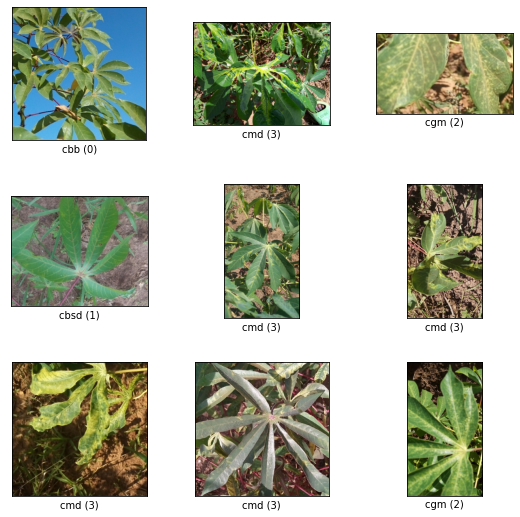

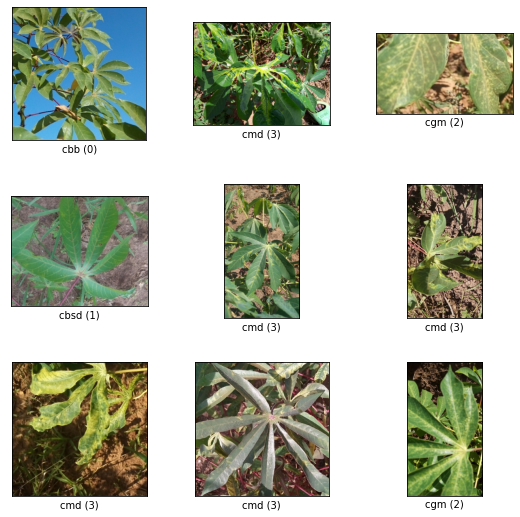

In [14]:
tfds.show_examples(train, info_train)

In [15]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    
    return tf.image.resize(image, [224, 224]), tf.one_hot(label, 3)

In [16]:
def get_dataset(batch_size = 32):
    train_dataset_sclaed = datasets[0].map(scale).shuffle(1000).batch(batch_size)
    test_dataset_sclaed = datasets[1].map(scale).batch(batch_size)
    validation_dataset_sclaed = datasets[2].map(scale).batch(batch_size)
    
    return train_dataset_sclaed, test_dataset_sclaed, validation_dataset_sclaed

In [17]:
train_dataset, test_dataset, val_dataset = get_dataset()

train_dataset.cache()
val_dataset.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
len(list(datasets[0]))

5656

In [19]:
feature_extractor = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [20]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (224, 224, 3))

In [21]:
feature_extractor_layer.trainable = False

In [22]:
model = tf.keras.Sequential(
    [
        feature_extractor_layer,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(3, activation = 'softmax')
    ]
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc']
)

In [25]:
hist = model.fit(train_dataset, epochs = 6, validation_data = val_dataset)

Epoch 1/6
177/177 [==============================] - 235s 1s/step - loss: 0.4807 - acc: 0.3335 - val_loss: 0.3770 - val_acc: 0.3875
Epoch 2/6
177/177 [==============================] - 224s 1s/step - loss: 0.4057 - acc: 0.3732 - val_loss: 0.3404 - val_acc: 0.3600
Epoch 3/6
177/177 [==============================] - 223s 1s/step - loss: 0.3819 - acc: 0.3838 - val_loss: 0.3314 - val_acc: 0.3737
Epoch 4/6
177/177 [==============================] - 227s 1s/step - loss: 0.3706 - acc: 0.3932 - val_loss: 0.3226 - val_acc: 0.3727
Epoch 5/6
177/177 [==============================] - 223s 1s/step - loss: 0.3579 - acc: 0.3927 - val_loss: 0.3138 - val_acc: 0.3584
Epoch 6/6
177/177 [==============================] - 224s 1s/step - loss: 0.3409 - acc: 0.4035 - val_loss: 0.3110 - val_acc: 0.3886


In [26]:
result = model.evaluate(test_dataset)

59/59 [==============================] - 58s 962ms/step - loss: 0.3316 - acc: 0.3804


In [27]:
%matplotlib inline

[[0.19488882 0.60193247 0.20317866]]


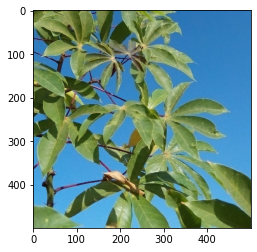

Actual Label : cbb
Predicted Label : cbsd
[[0.38413855 0.37689263 0.23896877]]


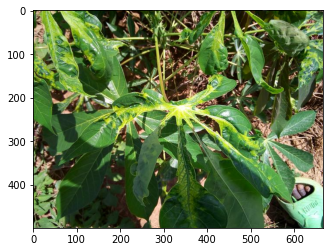

Actual Label : cmd
Predicted Label : cbb
[[0.28786474 0.61874205 0.09339327]]


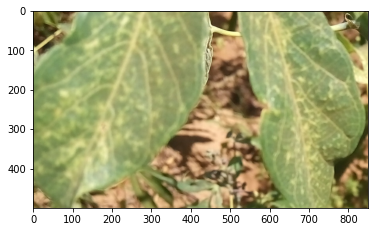

Actual Label : cgm
Predicted Label : cbsd
[[0.11436564 0.77776414 0.10787023]]


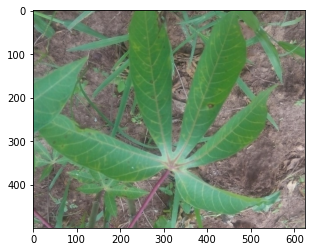

Actual Label : cbsd
Predicted Label : cbsd
[[0.20346025 0.47903007 0.31750974]]


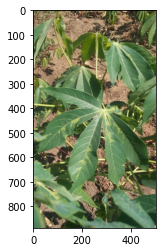

Actual Label : cmd
Predicted Label : cbsd
[[0.2131831  0.54131734 0.24549958]]


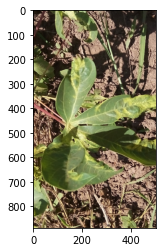

Actual Label : cmd
Predicted Label : cbsd
[[0.32003102 0.41917348 0.26079547]]


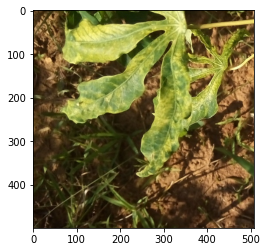

Actual Label : cmd
Predicted Label : cbsd
[[0.21737382 0.08112758 0.7014986 ]]


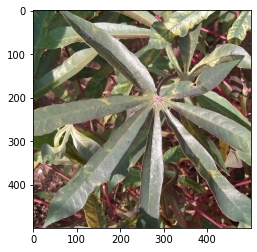

Actual Label : cmd
Predicted Label : cgm
[[0.2095532  0.13774747 0.65269935]]


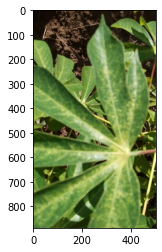

Actual Label : cgm
Predicted Label : cgm
[[0.10205669 0.72694176 0.1710015 ]]


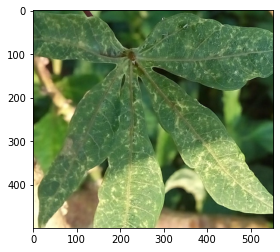

Actual Label : cgm
Predicted Label : cbsd


In [28]:
for test_sample in datasets[1].take(10):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(test_sample[0], test_sample[1])
    image_scaled = np.expand_dims(image_scaled, axis = 0)
    
    img = tf.keras.preprocessing.image.img_to_array(image)
    
    pred = model.predict(image_scaled)
    
    print(pred)
    
    plt.figure()
    plt.imshow(image)
    plt.show()
    
    print("Actual Label : %s" %info.features['label'].names[label.numpy()])
    print("Predicted Label : %s" %info.features['label'].names[np.argmax(pred)])

In [29]:
for f0, f1 in datasets[1].map(scale).batch(200):
    y = np.argmax(f1, axis = 1)
    y_pred = np.argmax(model.predict(f0), axis = 1)
    
    print(tf.math.confusion_matrix(labels = y, predictions = y_pred, num_classes = 3))

tf.Tensor(
[[12 80 35]
 [ 5 38  5]
 [ 2  6 17]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[10 68 46]
 [ 6 41  4]
 [ 1  4 20]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[12 65 30]
 [ 2 56  2]
 [ 3  5 25]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 9 61 45]
 [ 3 47  3]
 [ 1 10 21]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 8 72 47]
 [ 3 43  4]
 [ 4  3 16]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[14 66 41]
 [ 4 50  2]
 [ 1  2 20]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[12 74 39]
 [ 1 33  8]
 [ 2  7 24]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[12 63 43]
 [ 1 46  4]
 [ 2  4 25]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[12 64 48]
 [ 2 45  2]
 [ 2  4 21]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 6 29 23]
 [ 2 18  1]
 [ 2  0  4]], shape=(3, 3), dtype=int32)
